In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [4]:
cars = pd.read_csv('data/processed/used_cars.csv')
cars.head(), cars.shape

(   Unnamed: 0  year  price  acura  ...  red  silver  white  yellow
 0           0  2009   9000      0  ...    0       0      1       0
 1           1  2002   6000      0  ...    0       0      1       0
 2           2  2007   7000      0  ...    1       0      0       0
 3           3  2012  37000      0  ...    0       1      0       0
 4           4  2003   3700      0  ...    0       1      0       0
 
 [5 rows x 101 columns], (434542, 101))

In [5]:
target = cars['price'].to_numpy().reshape(-1, 1)
data = cars.drop(['price'], axis=1).to_numpy()

In [6]:
from sklearn.preprocessing import StandardScaler

# Scale for x
scaler_data = StandardScaler()
data_scaled = scaler_data.fit_transform(data)

# Scale for y 
scaler_target = StandardScaler()
target_scaled = scaler_target.fit_transform(target)

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data_scaled,
                                                  target_scaled, test_size=0.20)

## **Pytorch**

In [8]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [9]:
device = torch.device('cuda')

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(99, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=0.2, training=True)
        x = self.fc4(x)

        return x

In [11]:
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x).type(torch.float32)
        self.y = torch.tensor(y).type(torch.float32)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.x.shape[0]

In [12]:
trainset = dataset(x_train, y_train)
trainloader = DataLoader(trainset, batch_size=1024)

In [13]:
valset = dataset(x_val, y_val)
valloader = DataLoader(valset, batch_size=1024)

In [14]:
dataloaders = {
    'val' : valloader,
    'train': trainloader
}

In [15]:
class RunningMetrics():
    def __init__(self):
        self.S = 0
        self.N = 0 

    def update(self, val, size):
        self.S += val 
        self.N += size

    def __call__(self):
        return self.S / float(self.N)

In [16]:
def train_and_val(model, optimizer, loss_fn, dataloaders, num_epochs=100):
    losses_train = []
    losses_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = RunningMetrics()

            for inputs, targets in dataloaders[phase]:
                optimizer.zero_grad()
                inputs, targets = inputs.to(device), targets.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = loss_fn(outputs, targets)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update metrics
                epoch_size = outputs.shape[0]
                running_loss.update(loss.item() * epoch_size, epoch_size)
                
            print('{}: Loss {}'.format(phase.capitalize(), running_loss()))
            
            if phase == 'train':
                losses_train.append(running_loss())
            else:
                losses_val.append(running_loss())

        print('*' * 50)

    # Plot losses             
    plt.plot(range(len(losses_train)), losses_train, color='purple', label='train')
    plt.plot(range(len(losses_val)), losses_val, label='validation')
    plt.legend()
    plt.show()

In [17]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

Epoch 1/40
Train: Loss 0.5302238371788435
Val: Loss 0.4672623812578961
**************************************************
Epoch 2/40
Train: Loss 0.45722988831121897
Val: Loss 0.4515941771079652
**************************************************
Epoch 3/40
Train: Loss 0.44312887978494514
Val: Loss 0.4406538320532916
**************************************************
Epoch 4/40
Train: Loss 0.4309554236002382
Val: Loss 0.4345436659962778
**************************************************
Epoch 5/40
Train: Loss 0.421382912557935
Val: Loss 0.42708539668925455
**************************************************
Epoch 6/40
Train: Loss 0.4130458647554914
Val: Loss 0.4234181150289431
**************************************************
Epoch 7/40
Train: Loss 0.40545083748025934
Val: Loss 0.41970834621815634
**************************************************
Epoch 8/40
Train: Loss 0.3989357311513941
Val: Loss 0.4158795982097575
**************************************************
Epoch 9/40
Train: Lo

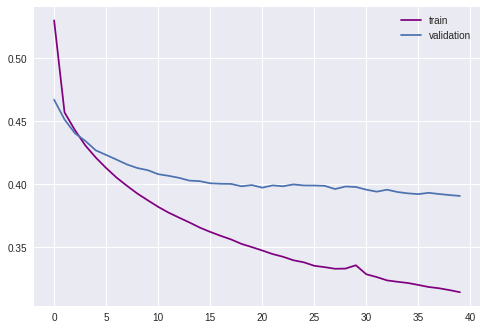

In [18]:
train_and_val(model, optimizer, loss_fn, dataloaders, num_epochs=40)

In [24]:
torch.save(model, 'prediction_prices.pt')